# Carregar as bibliotecas

In [62]:
import numpy as np
from skimage import io, transform, util, feature
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [35]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch
from torch import nn
import os

In [36]:
def matriz_confusao(y_test, y_pred, labels):
  matriz = metrics.confusion_matrix(y_test, y_pred)
  tot = np.sum(matriz, axis=1, keepdims=True)
  np.set_printoptions(precision=2)
  m_porc = matriz/tot
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=labels)
  disp.plot(values_format='.2f')
  plt.show()

### Base de dados

#### Datasets & DataLoaders

<p>
Pytorch trabalha com duas abstrações chamadas de Dataset e DataLoader. Elas são responsáveis por alimentar seu treinamento com os dados, fazendo isso de forma bem performática.

As imagens abaixo ilustram muito bem o papel de cada um:

<img src="https://i.imgur.com/KTKptDw.png" alt="redes neurais" style="width: 600px;"/>

<img src="https://i.imgur.com/dhd1XJy.png" alt="redes neurais" style="width: 600px;"/>

</p>

<p>
Na primeira imagem, vemos que o <b>Dataset</b> é responsável por acessar os dados e selecionar um item específico. Portanto, dois métodos são essenciais ao implementar o <b>Dataset</b>:

<ul>
    <li><i>__len__</i>: indica o tamanho do dataset.</li>
    <li><i>__getitem__</i>: coleta um item do dataset.</li>
</ul>
</p>

<p>
Na segunda imagem, observamos o <b>DataLoader</b> em ação, cuja função é solicitar itens específicos ao <b>Dataset</b>. Durante o treinamento, os dados são passados em lotes e embaralhados, fazendo com que os índices solicitados ao <b>Dataset</b> não sigam uma ordem específica.
</p>

<p>
Em termos de implementação, o método <i>__getitem__</i> deve retornar uma tupla contendo o item e o rótulo, seja ele um tensor de imagem, texto, som, etc. Seu trabalho é adaptar os dados brutos para essa estrutura.
</p>

<p>
Em alguns casos, o PyTorch facilita esse processo, eliminando a necessidade de criar uma classe <b>Dataset</b> do zero."
</p>

## Classe Dataset

<p>A base de dados MNIST (Modified National Institute of Standards and Technology) é um conjunto clássico e amplamente utilizado em tarefas de reconhecimento de padrões e aprendizado de máquina supervisionado. Ela contém 70.000 imagens em tons de cinza de dígitos manuscritos de 0 a 9, sendo 60.000 para treinamento e 10.000 para teste, todas com resolução de 28×28 pixels. Cada imagem representa um único dígito centralizado, com valores de pixel variando de 0 (preto) a 255 (branco). A MNIST é frequentemente utilizada como benchmark para algoritmos de classificação e redes neurais, especialmente em estudos introdutórios de aprendizado profundo e visão computacional. Essa base está disponível de forma integrada em bibliotecas como o PyTorch, facilitando seu carregamento, pré-processamento e uso em experimentos práticos.</p>

<img src="https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp" />

In [37]:
# Carrega o conjunto de treino
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [38]:
# Carrega o conjunto de teste
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

## Classe Datalaloader

<p>Usada para criar batches durante o treino</p>

In [39]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False)

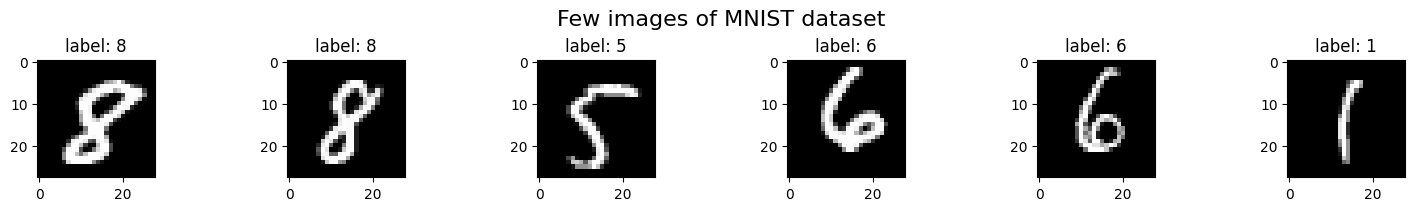

In [40]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

# Pytorch
## Rede Neural Artificial

In [41]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [42]:
class ModeloSkLearn(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super().__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

## Função para treinar

In [49]:
def meu_batch_fit(modelo, funcao_objetivo, otimizador, train_loader, epocas = 10):
    custos = []
    losses = np.zeros(epocas)
    modelo.train()
    for i in range(epocas):
        train_loss = []
        for x, y in train_loader:
            # zerar os gradientes
            otimizador.zero_grad()

            # reshape the input
            x = x.view(-1, 784)  # flatten 28x28 -> 784

            # forward pass
            y_predito = modelo(x)
            custo = funcao_objetivo(y_predito, y) # loss

            # backward pass
            custo.backward()
            otimizador.step()

            train_loss.append(custo.item())

        losses[i] = np.mean(train_loss)
        print(f'Epoch {i+1}/{epocas}, Train loss: {losses[i]:.4f}')

    return losses

## Função de validação / teste

In [50]:
def meu_batch_predict(modelo, test_loader):
    preds = np.array([])
    true_label = np.array([])
    modelo.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(-1, 784)  # flatten
            outputs = modelo(x)
            _, y_predito = torch.max(outputs, 1)
            preds = np.concatenate((preds, y_predito.cpu().numpy()))
            true_label = np.concatenate((true_label, y.cpu().numpy()))
    return preds, true_label

## Instanciação da rede e treinamento

In [51]:
# instanciar modelo neural
modelo = ModeloSkLearn(entrada=784, camadas_escondidas=[128, 64], saida=10)

# Funções de otimização e de custo
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.001)
funcao_objetivo = nn.CrossEntropyLoss()

# treinar o modelo
train_loss = meu_batch_fit(modelo, funcao_objetivo, otimizador, train_loader, epocas = 10)

Epoch 1/10, Train loss: 0.4104
Epoch 2/10, Train loss: 0.1722
Epoch 3/10, Train loss: 0.1201
Epoch 4/10, Train loss: 0.0912
Epoch 5/10, Train loss: 0.0730
Epoch 6/10, Train loss: 0.0601
Epoch 7/10, Train loss: 0.0495
Epoch 8/10, Train loss: 0.0417
Epoch 9/10, Train loss: 0.0341
Epoch 10/10, Train loss: 0.0283


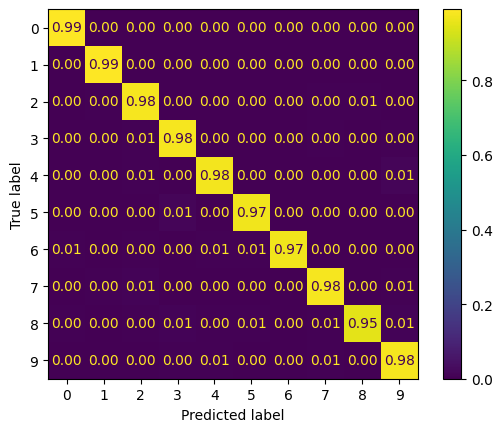

In [52]:
# avaliar o modelo
y_pred, Y_test = meu_batch_predict(modelo, test_loader)

# gerar matriz de confusão
matriz_confusao(Y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])


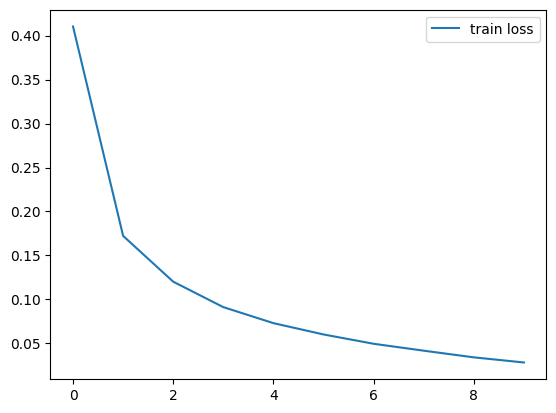

In [53]:
plt.plot(train_loss, label = 'train loss')
plt.legend()
plt.show()

# Usando uma base de imagens própria
## Treinamento a partir dos descritores de uma base propria de imagens

In [54]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-06-12 14:19:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   196MB/s    in 0.3s    

2025-06-12 14:19:12 (196 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [55]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [56]:
%ls /tmp/cats_and_dogs_filtered

train/  validation/  vectorize.py


In [57]:
!mv /tmp/cats_and_dogs_filtered/validation /tmp/cats_and_dogs_filtered/val

In [58]:
%ls /tmp/cats_and_dogs_filtered

train/  val/  vectorize.py


In [63]:
def feature_extraction(root_dir):
    # identifica as classes, um subdiretorio por classe
    classes = os.listdir(root_dir)
    # cria um dicionario onde associar o nome da classe a um valor numerico
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    # matriz de descritores
    dataset = []
    labels = []

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        # entra em cada subdiretorio
        for img_name in os.listdir(cls_dir):
            # lê a imagem
            img_path = os.path.join(cls_dir, img_name)
            img = io.imread(img_path)
            img = util.img_as_ubyte(img)
            # redimensionar a imagem para 50 x 50
            img = transform.resize(img, (50, 50))
            # usar o descritor HoG
            fd = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2), channel_axis=-1)
            # adiciona cada vetor de características na matriz
            dataset.append(fd)
            # adiciona os rótulos de cada imagem
            labels.append(class_to_idx[cls])

    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [64]:
dataTrain, labelTrain = feature_extraction('/tmp/cats_and_dogs_filtered/train')
dataVal, labelVal = feature_extraction('/tmp/cats_and_dogs_filtered/val')

In [65]:
print(dataTrain.shape)
print(labelTrain.shape)
print(dataVal.shape)
print(labelVal.shape)

(2000, 900)
(2000,)
(1000, 900)
(1000,)


In [67]:
# Normlizar os atributos
std_scaler = preprocessing.StandardScaler().fit(dataTrain)
dataTrain = std_scaler.transform(dataTrain)
dataVal = std_scaler.transform(dataVal)

### Instanciar uma MLP em SkLearn

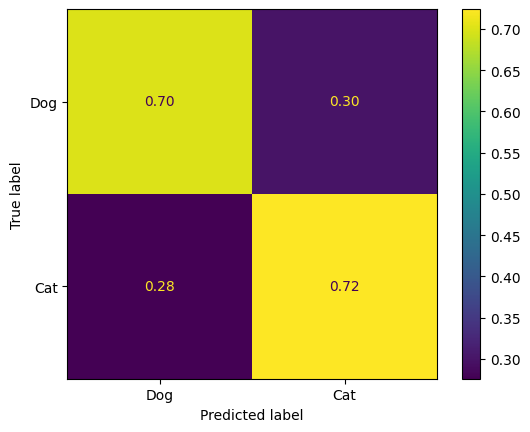

In [69]:
# Passo 1, importar biblioteca
from sklearn.neural_network import MLPClassifier

# Passo 2, instanciar o classificador
clf = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    solver='adam',
)

# Passo 3, treinar
clf.fit(dataTrain, labelTrain)

# Passo 4, avaliar o modelo
y_pred = clf.predict(dataVal)
matriz_confusao(labelVal, y_pred, labels=['Dog', 'Cat'])

### Realizar o mesmo processo com um classificador SVM

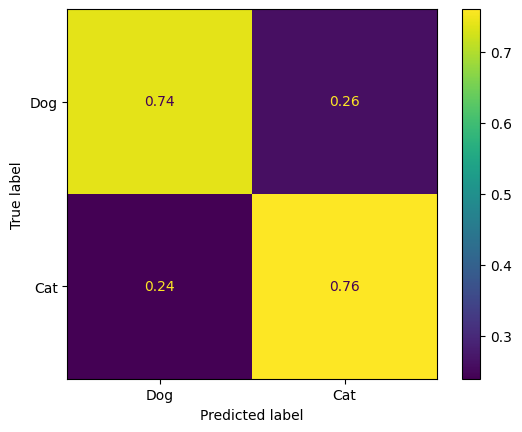

In [70]:
from sklearn.svm import SVC

# Passo 2, instanciar o classificador
clf_svm = SVC(kernel='rbf')

# Passo 3, treinar
clf_svm.fit(dataTrain, labelTrain)

# Passo 4, avaliar o modelo
y_pred = clf_svm.predict(dataVal)
matriz_confusao(labelVal, y_pred, labels=['Dog', 'Cat'])

### Treinar usando a MLP implementada em Pytorch

In [71]:
# Transforma tensores Numpy em tensores Torch
X_train = torch.tensor(dataTrain, dtype=torch.float32)
X_test = torch.tensor(dataVal, dtype=torch.float32)
Y_train = torch.tensor(labelTrain, dtype=torch.long)
Y_test = torch.tensor(labelVal, dtype=torch.long)

In [72]:
def meu_fit(modelo, funcao_objetivo, otimizador, data, labels, epocas = 100):
    custos = []
    for i in range(epocas):
        # zerar os gradientes
        otimizador.zero_grad()

        # forward pass
        y_predito = modelo(data)
        # cálculo do loss (erro)
        custo = funcao_objetivo(y_predito, labels)

        # backward pass, correção de pesos
        custo.backward()
        otimizador.step()

        custos.append(custo.item())
    return custos

In [73]:
def meu_predict(modelo, data):
    preds = []
    # deshabilitar atualização de pesos, rede em modo avaliação
    with torch.no_grad():
        for val in data:
            y_predito = modelo.forward(val)
            preds.append(y_predito.argmax().item())
    return preds

In [76]:
# instanciaçao do modelo, definir 128 e 32 neuronios nas camadas ocultas
modelo2 = ModeloSkLearn(entrada=900, camadas_escondidas=[128, 32], saida=2)

# definir funções de otimização e de perda (custo)
otimizador = torch.optim.Adam(modelo2.parameters(), lr=0.001)
funcao_objetivo = nn.CrossEntropyLoss()

# treinar o modelo
custos = meu_fit(modelo2, funcao_objetivo, otimizador, X_train, Y_train, epocas = 100)

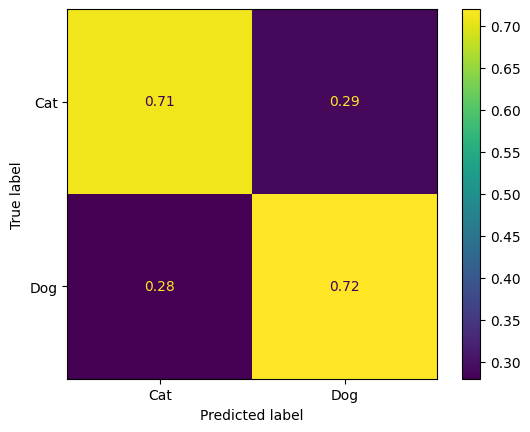

In [77]:
# avaliar o modelo
y_pred = meu_predict(modelo2, X_test)

# gerar matriz de confusão
matriz_confusao(Y_test, y_pred, labels=['Cat','Dog'])